# Goal

Goal of given work is to study methods of dealing with imbalanced ds

Up-sample the minority class
Down-sample the majority class
Change your performance metric
Penalize algorithms (cost-sensitive training)
Use tree-based algorithms

# Load



In [27]:
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split

from sklearn.utils import resample
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier


from sklearn.svm import SVC
from scipy import stats

# Data

In [3]:
df=load_breast_cancer()

x=pd.DataFrame(df['data'])
y=pd.DataFrame(df['target'])

x.columns=df['feature_names']
y.columns=['TARGET']

#Unbalanced Dataset
print('Classes_proportion')
y['TARGET'].value_counts()

Classes_proportion


1    357
0    212
Name: TARGET, dtype: int64

In [4]:
X_train,X_val,y_train,y_val=train_test_split(x,y,test_size=0.17,shuffle=True,random_state=1,stratify=y)

# With test size 17% we have best split - train equal to test
print('Share_0/1_train\n', y_train['TARGET'].value_counts()/len(y_train))
print('Share_0/1_test\n', y_val['TARGET'].value_counts()/len(y_val))
print('----------------------------------------------------------')
print('Same Share in train_test')

Share_0/1_train
 1    0.627119
0    0.372881
Name: TARGET, dtype: float64
Share_0/1_test
 1    0.628866
0    0.371134
Name: TARGET, dtype: float64
----------------------------------------------------------
Same Share in train_test


# Baseline

In [134]:
#score baseline

m=XGBClassifier(random_state=234,n_jobs=-1)
m.fit(X_train,y_train)
pred=m.predict(X_val)
pred_proba=m.predict_proba(X_val)
pred_1= [p[1] for p in pred_proba]
score=roc_auc_score(y_val,pred,average='weighted')
score_proba=roc_auc_score(y_val,pred_1,average='weighted')
print('Baseline_Score_AUC:', score)
print('Baseline_Score_Proba:', score_proba)

Baseline_Score_AUC: 0.9640255009107468
Baseline_Score_Proba: 0.9904371584699453


C:\anaconda1\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda1\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 1. Create more minor class samples (syntetic) and combine with major

In [56]:
y_train['TARGET'].value_counts()

1    296
0    176
Name: TARGET, dtype: int64

       Score  Minor
2   0.972222    178
32  0.972222    208
0   0.964026    176
9   0.964026    185


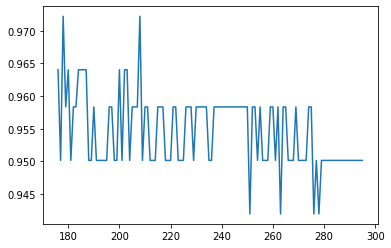

     Score_Proba  Minor
21      0.994080    197
117     0.994080    293
116     0.994080    292
20      0.993625    196


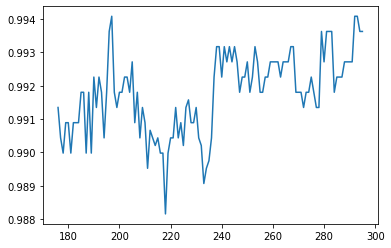

In [139]:
df=pd.concat([X_train,y_train],axis=1)
# Separate majority and minority classes
df_majority = df[df.TARGET==1]
df_minority = df[df.TARGET==0]
minor_i=[]
score_i=[]
score_proba=[]
for i in range(176,296):
# Upsample minority class
    minor_i.append(i)
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=i,    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    #print('We got balanced df')
    df_upsampled.TARGET.value_counts()

    m=XGBClassifier(random_state=234,n_jobs=-1)
    m.fit(df_upsampled.drop(['TARGET'],axis=1),df_upsampled.TARGET)
    pred=m.predict(X_val)
    pred_proba=m.predict_proba(X_val)
    pred_1= [p[1] for p in pred_proba]
    score=roc_auc_score(y_val,pred,average='weighted')
    scor_proba=roc_auc_score(y_val,pred_1,average='weighted')

    
    score_i.append(score)
    score_proba.append(scor_proba)
    
score_i=pd.DataFrame(score_i)
score_proba=pd.DataFrame(score_proba)
minor_i=pd.DataFrame(minor_i)

score_resample=pd.concat([score_i,minor_i],axis=1)
score_resample.columns=['Score','Minor']
score_resample=score_resample.sort_values(by=['Score'], ascending=False)

score_resample_proba=pd.concat([score_proba,minor_i],axis=1)
score_resample_proba.columns=['Score_Proba','Minor']
score_resample_proba=score_resample_proba.sort_values(by=['Score_Proba'], ascending=False)


print(score_resample[:4])
plt.plot(minor_i,score_i)
plt.show()
print(score_resample_proba[:4])
plt.plot(minor_i,score_proba)
plt.show()

##### So, by edding 178 minor values we managed to improve our baseline score AUC from 0.9640 to 0.9722.
##### So, by edding 197 minor values we managed to improve our baseline score AUC_PROBA from 0.9904 to 0.9940.



Conclusion: Adding some amount syntetic minor class can help to improve baseline score.
Should be tested on Test_data!

# 2. Down-sample Majority Class

        Score  Major
243  0.977914    245
254  0.977914    256
262  0.977914    264
261  0.977914    263


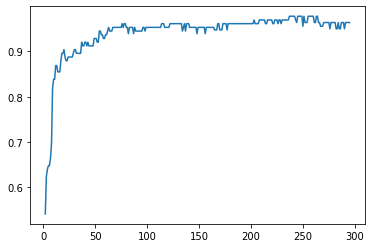

     Score_Proba  Major
236     0.994991    238
254     0.994536    256
261     0.994536    263
253     0.994080    255


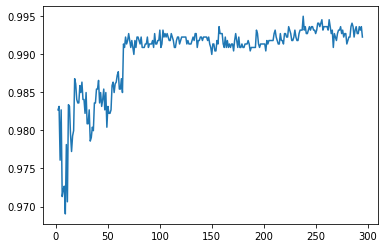

In [144]:
df=pd.concat([X_train,y_train],axis=1)
# Separate majority and minority classes
df_majority = df[df.TARGET==1]
df_minority = df[df.TARGET==0]
major_i=[]
score_i=[]
score_proba=[]
for i in range(2,296):
# Upsample minority class
    major_i.append(i)
    df_majority_upsampled = resample(df_majority, 
                                     replace=True,     # sample with replacement
                                     n_samples=i,    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_downsampled = pd.concat([df_minority, df_majority_upsampled])

    # Display new class counts
    #print('We got balanced df')
    df_downsampled.TARGET.value_counts()

    m=XGBClassifier(random_state=234,n_jobs=-1)
    m.fit(df_downsampled.drop(['TARGET'],axis=1),df_downsampled.TARGET)
    pred=m.predict(X_val)
    pred_proba=m.predict_proba(X_val)
    pred_1= [p[1] for p in pred_proba]
    score=roc_auc_score(y_val,pred,average='weighted')
    scor_proba=roc_auc_score(y_val,pred_1,average='weighted')

    
    score_i.append(score)
    score_proba.append(scor_proba)
    
score_i=pd.DataFrame(score_i)
score_proba=pd.DataFrame(score_proba)
major_i=pd.DataFrame(major_i)

score_resample=pd.concat([score_i,major_i],axis=1)
score_resample.columns=['Score','Major']
score_resample=score_resample.sort_values(by=['Score'], ascending=False)

score_resample_proba=pd.concat([score_proba,major_i],axis=1)
score_resample_proba.columns=['Score_Proba','Major']
score_resample_proba=score_resample_proba.sort_values(by=['Score_Proba'], ascending=False)


print(score_resample[:4])
plt.plot(major_i,score_i)
plt.show()
print(score_resample_proba[:4])
plt.plot(major_i,score_proba)
plt.show()


##### So, by dropping 238 major values we managed to improve our baseline AUC_PROBA score from 0.990 to 0.9949.

# 3. Change your Performance metric. F.e. ROC_AUC_PROBA for calssification

# 4. Penalize Algorithms (Cost-Sensitive Training)

The next tactic is to use penalized learning algorithms that increase the cost of classification mistakes on the minority class.

A popular algorithm for this technique is Penalized-SVM:

During training, we can use the argument 
- class_weight='balanced'  
to penalize mistakes on the minority class by an amount proportional to how under-represented it is.

We also want to include the argument 
- probability=True  
if we want to enable probability estimates for SVM algorithms.

In [7]:
# Separate input features (X) and target variable (y)
 
# Train model
for i in ['linear','rbf']:
    clf_3 = SVC(kernel=i, 
                class_weight='balanced', # penalize
                probability=True)

    clf_3.fit(X_train, y_train)

    prob_y_3 = clf_3.predict_proba(X_val)
    prob_y_3 = [p[1] for p in prob_y_3]
    print( roc_auc_score(y_val, prob_y_3,average='weighted') )

C:\anaconda1\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9918032786885246
0.964936247723133
0.9685792349726776


C:\anaconda1\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda1\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda1\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8588342440801457


C:\anaconda1\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Precomputed matrix must be a square matrix. Input is a 472x30 matrix.

So, by using SVC we managed to improve our baseline AUC_PROBA score from 0.990 to 0.9918

# 5. Tree Algor

In [15]:
clf_3 = RandomForestClassifier(random_state=243)

clf_3.fit(X_train, y_train)

prob = clf_3.predict_proba(X_val)
prob = [p[1] for p in prob]
print( roc_auc_score(y_val, prob,average='weighted') )

C:\anaconda1\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.9840619307832423


### RF score worse than XGBOOST, both untuned

# 6. SMOTE resampling minority class with perturbing features

For example, the SMOTE algorithm is a method of resampling from the minority class while slightly perturbing feature values, thereby creating "new" samples.

# 7. Combine Minority Classes

Combining minority classes of your target variable may be appropriate for some multi-class problems.

For example, let's say you wished to predict credit card fraud. In your dataset, each method of fraud may be labeled separately, but you might not care about distinguishing them. You could combine them all into a single 'Fraud' class and treat the problem as binary classification.

# 8. Reframe as Anomaly Detection
Anomaly detection, a.k.a. outlier detection, is for detecting outliers and rare events. Instead of building a classification model, you'd have a "profile" of a normal observation. If a new observation strays too far from that "normal profile," it would be flagged as an anomaly.

## QR_Quantile

In [17]:
df=pd.concat([X_train,y_train],axis=1)

In [19]:
#difference of dispersion between 25% 75% Quantile
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

mean radius                  4.025000
mean texture                 5.522500
mean perimeter              28.520000
mean area                  344.600000
mean smoothness              0.018800
mean compactness             0.063842
mean concavity               0.100565
mean concave points          0.052610
mean symmetry                0.033350
mean fractal dimension       0.008158
radius error                 0.248300
texture error                0.645550
perimeter error              1.763000
area error                  27.072500
smoothness error             0.003045
compactness error            0.018923
concavity error              0.027295
concave points error         0.006798
symmetry error               0.008088
fractal dimension error      0.002265
worst radius                 5.417500
worst texture                8.662500
worst perimeter             40.190000
worst area                 522.650000
worst smoothness             0.029675
worst compactness            0.197850
worst concav

(472, 31)

In [23]:
df_drop_QR = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5* IQR))).any(axis=1)]
print('Initial df shape',df.shape)
print('DF_drop_QR  shape',df_drop_QR.shape)

Initial df shape (472, 31)
DF_drop_QR  shape (328, 31)


In [26]:
# usually i=1.5
for i in [2.5,2,1.5,1.2,1.1]:
    print ('Threshold for data range',i)
    df_drop_QR = df[~((df < (Q1 - i * IQR)) |(df > (Q3 + i* IQR))).any(axis=1)]
    print ('Len DS',len(df_drop_QR))
    x=df_drop_QR.drop(['TARGET'],axis=1)
    y=X=df_drop_QR['TARGET']
    X_train,X_val,y_train,y_val=train_test_split(x,y,test_size=0.17,shuffle=True,random_state=1,stratify=y)
    m=XGBClassifier(random_state=234,n_jobs=-1)
    m.fit(X_train,y_train)

    pred_proba=m.predict_proba(X_val)
    pred_1= [p[1] for p in pred_proba]

    score_proba=roc_auc_score(y_val,pred_1,average='weighted')

    print('Baseline_Score_Proba:', score_proba)

Threshold for data range 2.5
Len DS 409
Baseline_Score_Proba: 0.9981060606060607
Threshold for data range 2
Len DS 379
Baseline_Score_Proba: 0.9668192219679634
Threshold for data range 1.5
Len DS 328
Baseline_Score_Proba: 0.9964221824686942
Threshold for data range 1.2
Len DS 286
Baseline_Score_Proba: 0.9871794871794872
Threshold for data range 1.1
Len DS 268
Baseline_Score_Proba: 1.0


##### So, changing thredhold for outliars to 2,5 and 1.1  we managed to improve our baseline AUC_PROBA score from 0.990 to 0.9981 and 1

## Z_score
Drop by individual column deviation

In [28]:
z = np.abs(stats.zscore(df['worst area']))
print(z)

[1.65530504e-01 5.38484026e-01 9.09489547e-01 7.67462612e-01
 8.75665177e-01 5.38405986e-01 2.86837799e-01 6.77763049e-02
 6.27737860e-01 5.20696891e-01 7.14335330e-01 8.40246989e-01
 5.99103605e+00 7.61795702e-01 1.23260247e+00 1.70056829e-01
 4.27448006e-01 1.34062795e+00 2.25618811e+00 5.59734939e-01
 5.70006213e-01 1.27909185e-01 6.30939004e-02 5.62037121e-01
 2.03305353e+00 2.30699970e-01 9.42173331e-01 1.03876593e+00
 6.69885504e-01 1.01078556e+00 1.68241346e+00 2.96102056e-03
 1.27333339e+00 3.06862582e-02 2.22553787e-01 1.88075532e+00
 9.47564099e-01 7.70473158e-01 7.75163067e-02 1.10155518e+00
 1.92271236e-01 4.95450927e-01 1.10003940e+00 2.01534443e+00
 3.38425740e+00 1.37604614e+00 1.37250432e+00 7.02647328e-01
 4.61803648e-01 2.87191981e-01 1.29635521e+00 6.08434947e-01
 8.42194989e-01 7.03355692e-01 5.74964759e-01 9.27375732e-01
 4.09129599e-01 5.52651301e-01 4.50292737e-01 2.82587616e-01
 4.15283209e+00 1.00238425e+00 8.89655361e-01 1.05434994e+00
 6.18529131e-01 6.017054

In [37]:
threshold = 1.8
df_train_Z = df[(z < threshold)]
df_train_Z.shape

(444, 31)

In [38]:
x=df_train_Z.drop(['TARGET'],axis=1)
y=df_train_Z['TARGET']
X_train,X_val,y_train,y_val=train_test_split(x,y,test_size=0.17,shuffle=True,random_state=1,stratify=y)
m=XGBClassifier(random_state=234,n_jobs=-1)
m.fit(X_train,y_train)

pred_proba=m.predict_proba(X_val)
pred_1= [p[1] for p in pred_proba]

score_proba=roc_auc_score(y_val,pred_1,average='weighted')

print('Baseline_Score_Proba:', score_proba)

Baseline_Score_Proba: 0.9741176470588235


In [41]:
model=['XGBoost base','Add minor-197','Drop major-238','Penalize SVC,linear','RF','QR outliars,2.5',
      'QR outliars,1.1','Z_score untuned']
score=[0.9904,0.9940,0.9949,0.9918,0.984,0.9981,1,0.9]

mod=pd.DataFrame(model)
sc=pd.DataFrame(score)

df=pd.concat([mod,sc],axis=1)
df.columns=['Model','Score']

In [53]:
df.sort_values(by=['Score'],ascending=False)

,Model,Score
6,"QR outliars,1.1",1.0000
5,"QR outliars,2.5",0.9981
2,Drop major-238,0.9949
1,Add minor-197,0.9940
3,"Penalize SVC,linear",0.9918
0,XGBoost base,0.9904
4,RF,0.9840
7,Z_score untuned,0.9000
